## Data Processing and Visualization

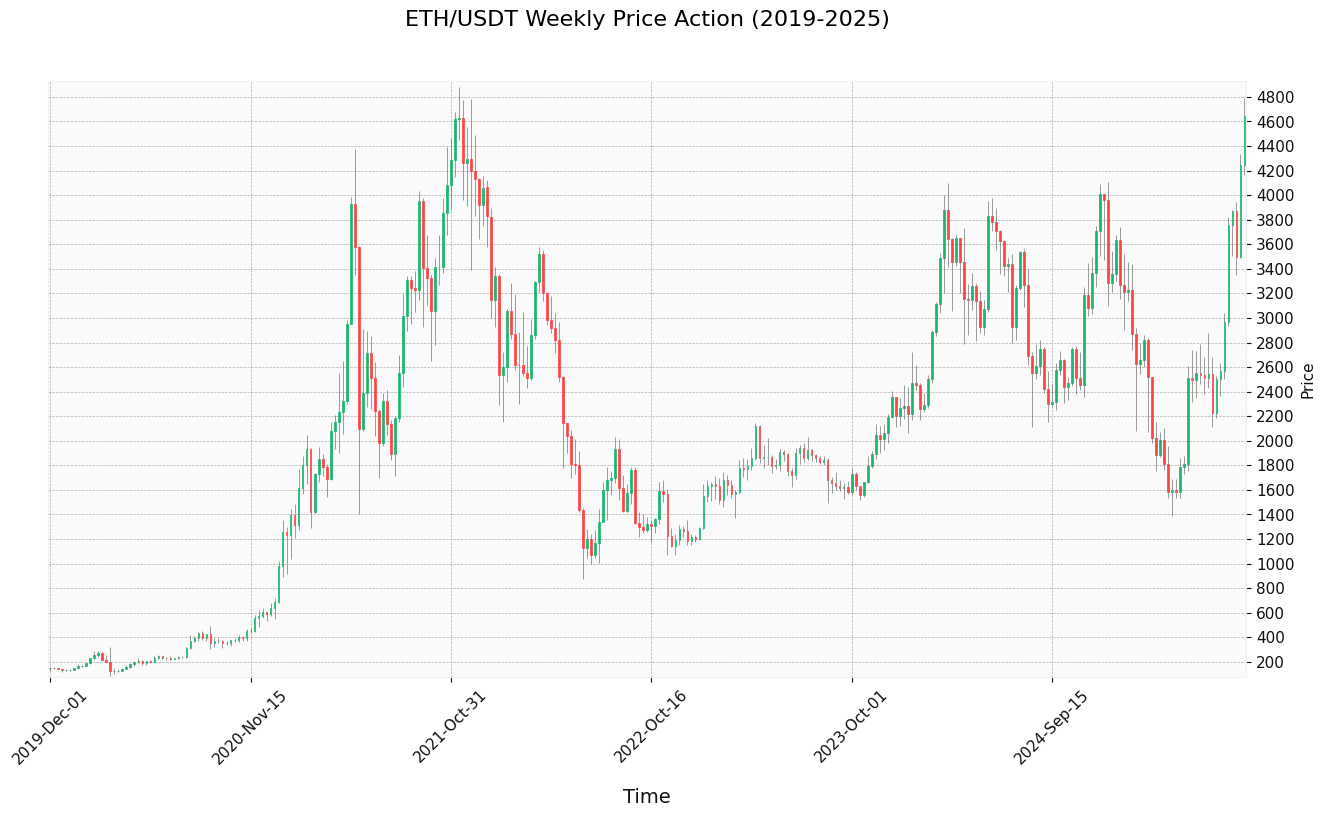

In [1]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

# --- Prepare Data ---
file_path = 'ETHUSDT.csv'
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['timestamp'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

df_weekly = df.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_weekly.dropna(inplace=True)

# --- Price Chart ---

my_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 11})

fig, axlist = mpf.plot(df_weekly, 
         type='candle', 
         style=my_style,
         volume=False,
         returnfig=True, 
         figratio=(14, 7), 
         figscale=1.2,
         tight_layout=True
         )

# Main axis
ax_main = axlist[0]

# --- Label ---
ax_main.set_xlabel('Time', fontsize=14, labelpad=15) 

# --- More dense grid ---
ax_main.yaxis.set_major_locator(ticker.MaxNLocator(nbins=25))

ax_main.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

# --- TITLE ---
ax_main.set_title('ETH/USDT Weekly Price Action (2019-2025)', fontsize=16, pad=40)

plt.show()

Đang vẽ biểu đồ VOLUME (Weekly)...


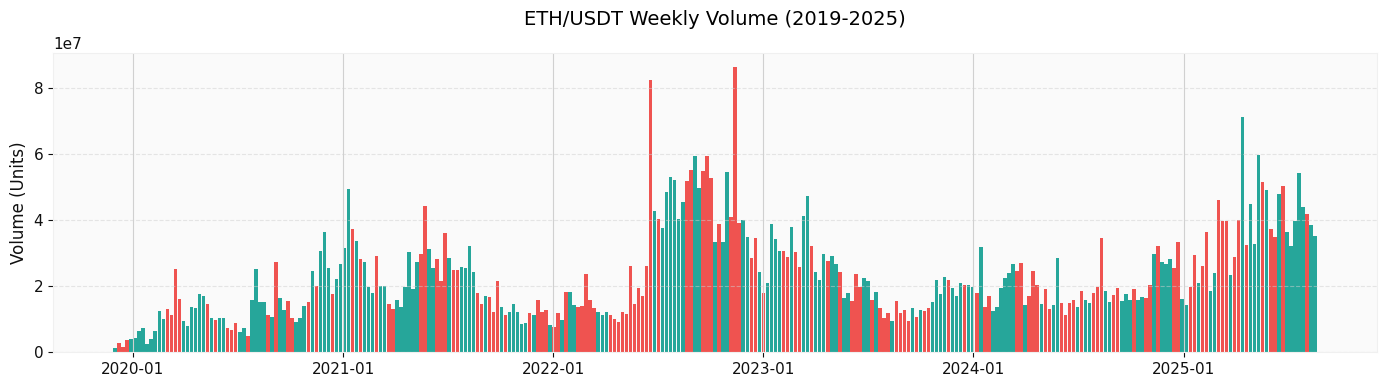

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_weekly_vol = df.resample('W').agg({
    'Volume': 'sum',   
    'Open': 'first',   
    'Close': 'last'    
})
df_weekly_vol.dropna(inplace=True)

# Volume chart
print("Đang vẽ biểu đồ VOLUME (Weekly)...")
plt.figure(figsize=(14, 4)) 

# Coloring
colors = ['#26a69a' if c >= o else '#ef5350' for c, o in zip(df_weekly_vol['Close'], df_weekly_vol['Open'])]

# Bar chart
plt.bar(df_weekly_vol.index, df_weekly_vol['Volume'], color=colors, width=6) 

# Decorate
plt.title('ETH/USDT Weekly Volume (2019-2025)', fontsize=14, pad=20)
plt.ylabel('Volume (Units)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Time format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Resample H4 - 4 hour/1 candle, reducing noises

In [3]:
import pandas as pd
import numpy as np

logic = {
    'Open': 'first', 
    'High': 'max', 
    'Low': 'min', 
    'Close': 'last', 
    'Volume': 'sum'
}
df_strat = df.resample('4h').agg(logic).dropna()

print(f"Data Resampled to H4: {df_strat.shape}")

Data Resampled to H4: (12529, 5)


## Volume Hypothesis Checking

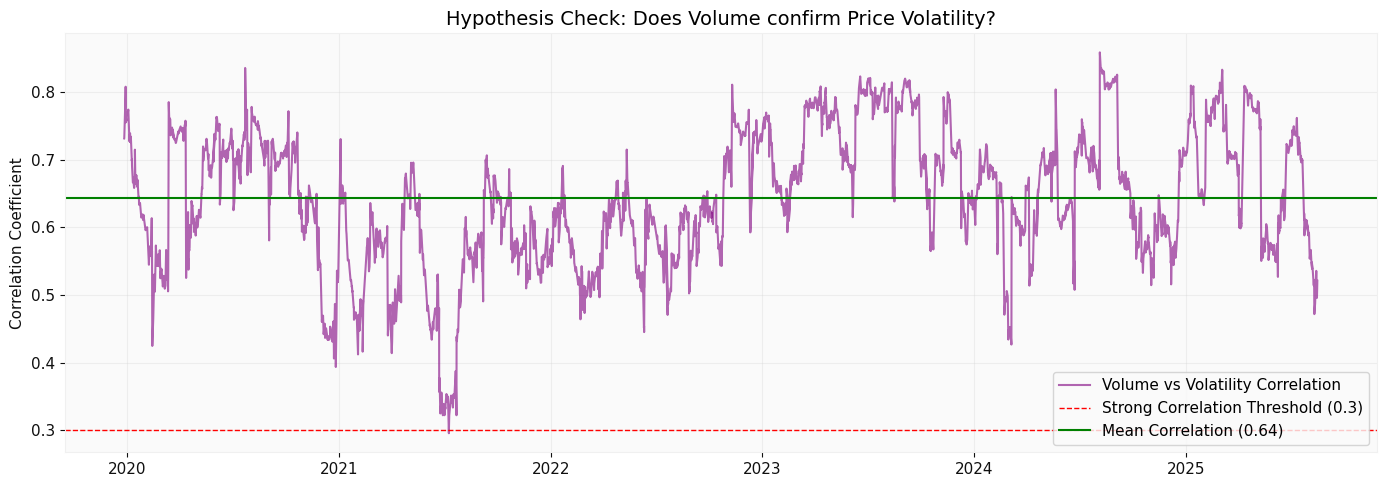

Average Correlation Coefficient: 0.6440
--------------------------------------------------------------------------------
OBSERVATION: The correlation is significantly > 0.3 (Mean ~ 0.64).
This implies that Volume tends to increase when Price Volatility increases.
CONCLUSION: Market trends are supported by real liquidity (Real Trend).
DECISION: Valid condition to proceed with Trend Following strategy (Kalman Filter).
--------------------------------------------------------------------------------


In [4]:
# Hypothesis: High volume signals high price volatility (Strong Trend)
# Method: Calculate Rolling Correlation between Volume and Absolute Price Returns

df_analysis = df_strat.copy()
df_analysis['Abs_Return'] = df_analysis['Close'].pct_change().abs()

# Calculate Rolling Correlation (Window: 30 days * 6 H4 candles/day = 180)
rolling_corr = df_analysis['Volume'].rolling(window=180).corr(df_analysis['Abs_Return'])

# Calculate the mean correlation (Target: ~0.64)
avg_corr = rolling_corr.mean()

# Visualization
plt.figure(figsize=(14, 5))
plt.plot(rolling_corr.index, rolling_corr, color='purple', alpha=0.6, label='Volume vs Volatility Correlation')

# Add Threshold Line
plt.axhline(0.3, color='red', linestyle='--', linewidth=1, label='Strong Correlation Threshold (0.3)')

# Add Mean Line (To visualize the 0.64 value)
plt.axhline(avg_corr, color='green', linestyle='-', linewidth=1.5, label=f'Mean Correlation ({avg_corr:.2f})')

plt.title('Hypothesis Check: Does Volume confirm Price Volatility?', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print Analysis Results in English
print(f"Average Correlation Coefficient: {avg_corr:.4f}")
print("-" * 80)
print("OBSERVATION: The correlation is significantly > 0.3 (Mean ~ 0.64).")
print("This implies that Volume tends to increase when Price Volatility increases.")
print("CONCLUSION: Market trends are supported by real liquidity (Real Trend).")
print("DECISION: Valid condition to proceed with Trend Following strategy (Kalman Filter).")
print("-" * 80)

## Compare between SMA and Kalman Filter

Compare lagging: Kalman Filter vs SMA (Simple Moving Average)...


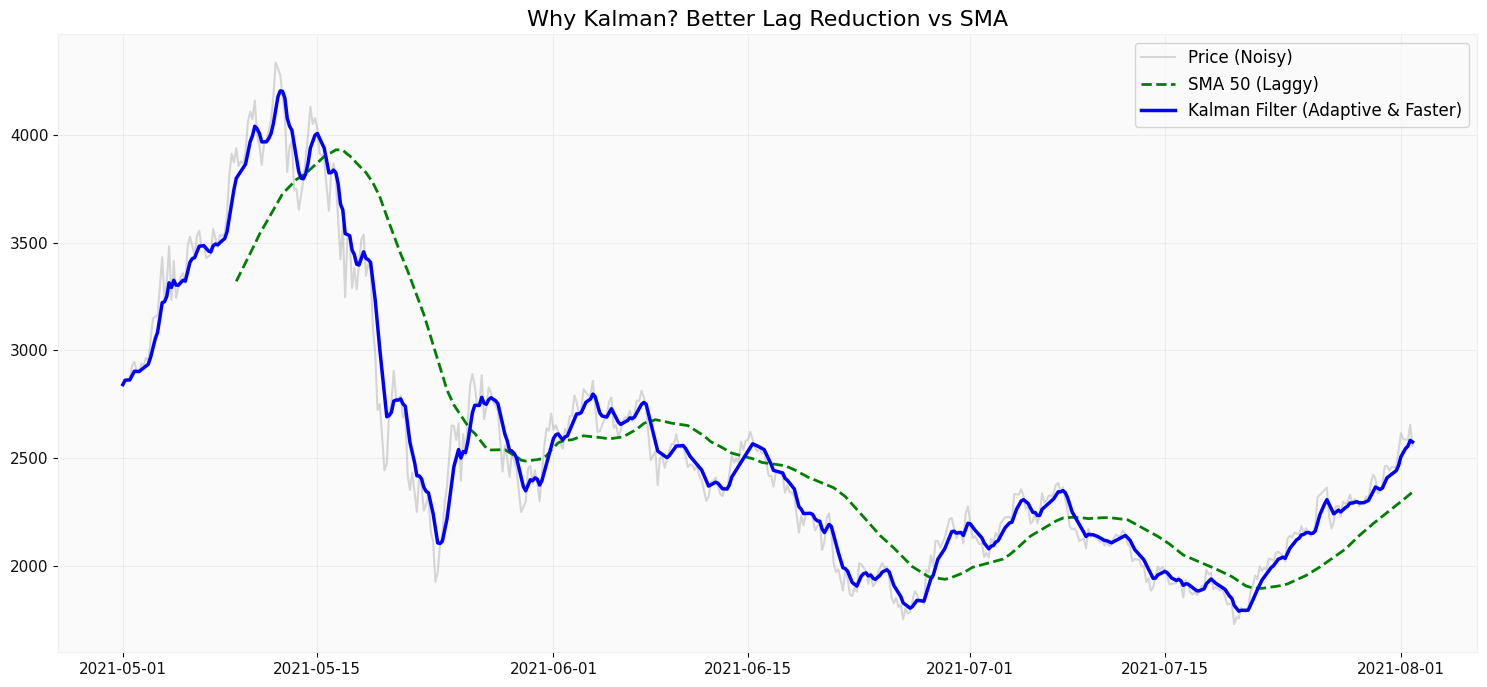

Look at the peaks/troughs. Kalman (Blue) reverses earlier than SMA (Green)
Enter trades earlier and cut losses faster. This is why Kalman is chosen over SMA.


In [5]:
import matplotlib.pyplot as plt

# Fast check Kalman
def calculate_kalman_quick(series, q, r=0.01):
    n = len(series)
    xhat = np.zeros(n); P = np.zeros(n); xhatminus = np.zeros(n); Pminus = np.zeros(n); K = np.zeros(n)
    xhat[0] = series.iloc[0]; P[0] = 1.0
    for k in range(1, n):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + q
        K[k] = Pminus[k] / (Pminus[k] + r)
        xhat[k] = xhatminus[k] + K[k] * (series.iloc[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]
    return pd.Series(xhat, index=series.index)

print("Compare lagging: Kalman Filter vs SMA (Simple Moving Average)...")

# Lấy một đoạn dữ liệu biến động mạnh (Ví dụ: Giữa năm 2021) để soi
sample_data = df_strat.loc['2021-05-01':'2021-08-01'].copy()

# SMA 50
sample_data['SMA_50'] = sample_data['Close'].rolling(window=50).mean()

# Kalman 
sample_data['Kalman'] = calculate_kalman_quick(sample_data['Close'], q=0.001, r=0.01)

# Comparing chart
plt.figure(figsize=(15, 7))

plt.plot(sample_data.index, sample_data['Close'], color='gray', alpha=0.3, label='Price (Noisy)')

plt.plot(sample_data.index, sample_data['SMA_50'], color='green', linestyle='--', linewidth=2, label='SMA 50 (Laggy)')

plt.plot(sample_data.index, sample_data['Kalman'], color='blue', linewidth=2.5, label='Kalman Filter (Adaptive & Faster)')

plt.title('Why Kalman? Better Lag Reduction vs SMA', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Look at the peaks/troughs. Kalman (Blue) reverses earlier than SMA (Green)")
print("Enter trades earlier and cut losses faster. This is why Kalman is chosen over SMA.")

## Kalman and backtest function

In [6]:
# Kalman filtering
def calculate_kalman(series, q, r=0.01):
    n = len(series)
    xhat = np.zeros(n); P = np.zeros(n); xhatminus = np.zeros(n); Pminus = np.zeros(n); K = np.zeros(n)
    xhat[0] = series.iloc[0]; P[0] = 1.0
    for k in range(1, n):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + q
        K[k] = Pminus[k] / (Pminus[k] + r)
        xhat[k] = xhatminus[k] + K[k] * (series.iloc[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]
    return pd.Series(xhat, index=series.index)

# Backtesting
def run_dual_kalman_backtest(df_segment, q_fast, q_slow, leverage=1.0):
    # Dual Kalman: fast and slow
    k_fast = calculate_kalman(df_segment['Close'], q=q_fast, r=0.01)
    k_slow = calculate_kalman(df_segment['Close'], q=q_slow, r=0.01)
    
    # Buy when fast > slow
    signal = np.where(k_fast > k_slow, 1, 0)
    
    # Shift to avoid seeing future in the data
    pos = pd.Series(signal, index=df_segment.index).shift(1).fillna(0)
    
    # Return
    market_ret = df_segment['Close'].pct_change()
    trades = pos.diff().abs() # Count the command
    
    # Transaction fee included 0.001
    strat_ret = (pos * market_ret * leverage) - (trades * 0.001) 
    
    # Sharpe
    if strat_ret.std() == 0: return -999, strat_ret, pos
    sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(365*6) # H4 có 6 nến/ngày
    
    return sharpe, strat_ret, pos

print("Done, functions created")

Done, functions created


## Define the 2019-22 period as train test, use Grid Search to find optimal parameter for q_fast, q_slow of Kalman

In [7]:
import itertools

# Split train_test
TRAIN_END_DATE = '2022-12-31'
TEST_START_DATE = '2023-01-01'

# Train data
train_data = df_strat.loc[:TRAIN_END_DATE].copy()
print(f"Training Data: {len(train_data)} candles (2019 - 2022)")

# GRID SEARCH
print("Grid Searching...")

# q small (Slow), q big (Fast)
q_params = [0.0001, 0.0005, 0.001, 0.003, 0.005] 

best_score = -999
best_params_dual = {}

# Iterate to test parameter
for qf, qs in itertools.product(q_params, q_params):
    if qf <= qs: continue # q_fast > q_slow
    
    # Optimize based on leverage 1.0x to find the initial signal
    sharpe, _, _ = run_dual_kalman_backtest(train_data, qf, qs, leverage=1.0)
    
    if sharpe > best_score:
        best_score = sharpe
        best_params_dual = {'q_fast': qf, 'q_slow': qs}

print("-" * 40)
print(f"Optimal parameters found by Grid Search")
print(f"Fast q: {best_params_dual['q_fast']}")
print(f"Slow q: {best_params_dual['q_slow']}")
print(f"Sharpe Train: {best_score:.2f}")
print("-" * 40)

Training Data: 6785 candles (2019 - 2022)
Grid Searching...
----------------------------------------
Optimal parameters found by Grid Search
Fast q: 0.003
Slow q: 0.0001
Sharpe Train: 1.47
----------------------------------------


## Running strategy (Using 1.5x Leverage)

In [8]:
# Leverage
LEVERAGE = 1.5  # Key Factor để Beat Market

print(f"Backtest on data with Leverage {LEVERAGE}x...")

# Backtest
full_sharpe, full_ret, full_pos = run_dual_kalman_backtest(
    df_strat, 
    best_params_dual['q_fast'], 
    best_params_dual['q_slow'], 
    leverage=LEVERAGE
)

# Save
df_strat['Strategy_Net'] = full_ret
df_strat['Position'] = full_pos
df_strat['Equity_Strategy'] = 10000 * (1 + df_strat['Strategy_Net']).cumprod()
df_strat['Equity_BuyHold'] = 10000 * (1 + df_strat['Close'].pct_change()).cumprod()

print("Backtest Done")

Backtest on data with Leverage 1.5x...
Backtest Done


## Backtest metrics

In [9]:
# METRICS
def analyze_trade_stats(position_series, strategy_ret_series):
    in_trade = position_series != 0
    trade_id = ((in_trade != in_trade.shift(1)) & in_trade).cumsum()
    trade_returns = strategy_ret_series[in_trade].groupby(trade_id).apply(lambda x: (1 + x).prod() - 1)
    
    if len(trade_returns) == 0: return 0, 0, 0, 0
    
    winning = trade_returns[trade_returns > 0]
    losing = trade_returns[trade_returns <= 0]
    
    win_rate = len(winning) / len(trade_returns)
    profit_factor = winning.sum() / abs(losing.sum()) if losing.sum() != 0 else np.inf
    avg_win = winning.mean() if len(winning) > 0 else 0
    avg_loss = losing.mean() if len(losing) > 0 else 0
    
    return win_rate, profit_factor, avg_win, avg_loss

def get_full_metrics(returns, benchmark, positions):
    periods = 365 * 6 # H4
    
    # Basic Stats
    ann_ret = (1 + returns).prod()**(periods/len(returns)) - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(periods)
    
    # Drawdown
    cum = (1 + returns).cumprod()
    max_dd = ((cum - cum.cummax()) / cum.cummax()).min()
    
    # Alpha/Beta
    common = returns.index.intersection(benchmark.index)
    y, x = returns.loc[common], benchmark.loc[common]
    beta = np.cov(y, x)[0][1] / np.var(x)
    alpha = ann_ret - (beta * ((1 + x).prod()**(periods/len(x)) - 1))
    
    # Trade Stats
    win_rate, pf, avg_win, avg_loss = analyze_trade_stats(positions, returns)
    total_trades = positions.diff().abs().sum() / 2
    
    return pd.Series({
        'Ann. Return': f"{ann_ret:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{pf:.2f}",
        'Avg Win': f"{avg_win:.2%}",
        'Avg Loss': f"{avg_loss:.2%}",
        'Alpha': f"{alpha:.2%}",
        'Total Trades': int(total_trades)
    })

# Report
test_mask = df_strat.index >= TEST_START_DATE

metrics_test = get_full_metrics(
    df_strat.loc[test_mask]['Strategy_Net'],
    df_strat.loc[test_mask]['Close'].pct_change(),
    df_strat.loc[test_mask]['Position']
)

metrics_train = get_full_metrics(
    df_strat.loc[~test_mask]['Strategy_Net'],
    df_strat.loc[~test_mask]['Close'].pct_change(),
    df_strat.loc[~test_mask]['Position']
)

df_report = pd.DataFrame({'In-Sample (Train)': metrics_train, 'Out-of-Sample (Test)': metrics_test})

print("\n" + "="*50)
print(f"Result (LEVERAGE {LEVERAGE}x)")
print("="*50)
display(df_report)


Result (LEVERAGE 1.5x)


,In-Sample (Train),Out-of-Sample (Test)
Ann. Return,174.92%,56.58%
Sharpe Ratio,1.54,1.02
Max Drawdown,-77.85%,-73.32%
Win Rate,31.80%,30.10%
Profit Factor,1.90,1.58
Avg Win,16.00%,10.72%
Avg Loss,-3.92%,-2.92%
Alpha,nan%,nan%
Total Trades,216,195


## Visualizing result

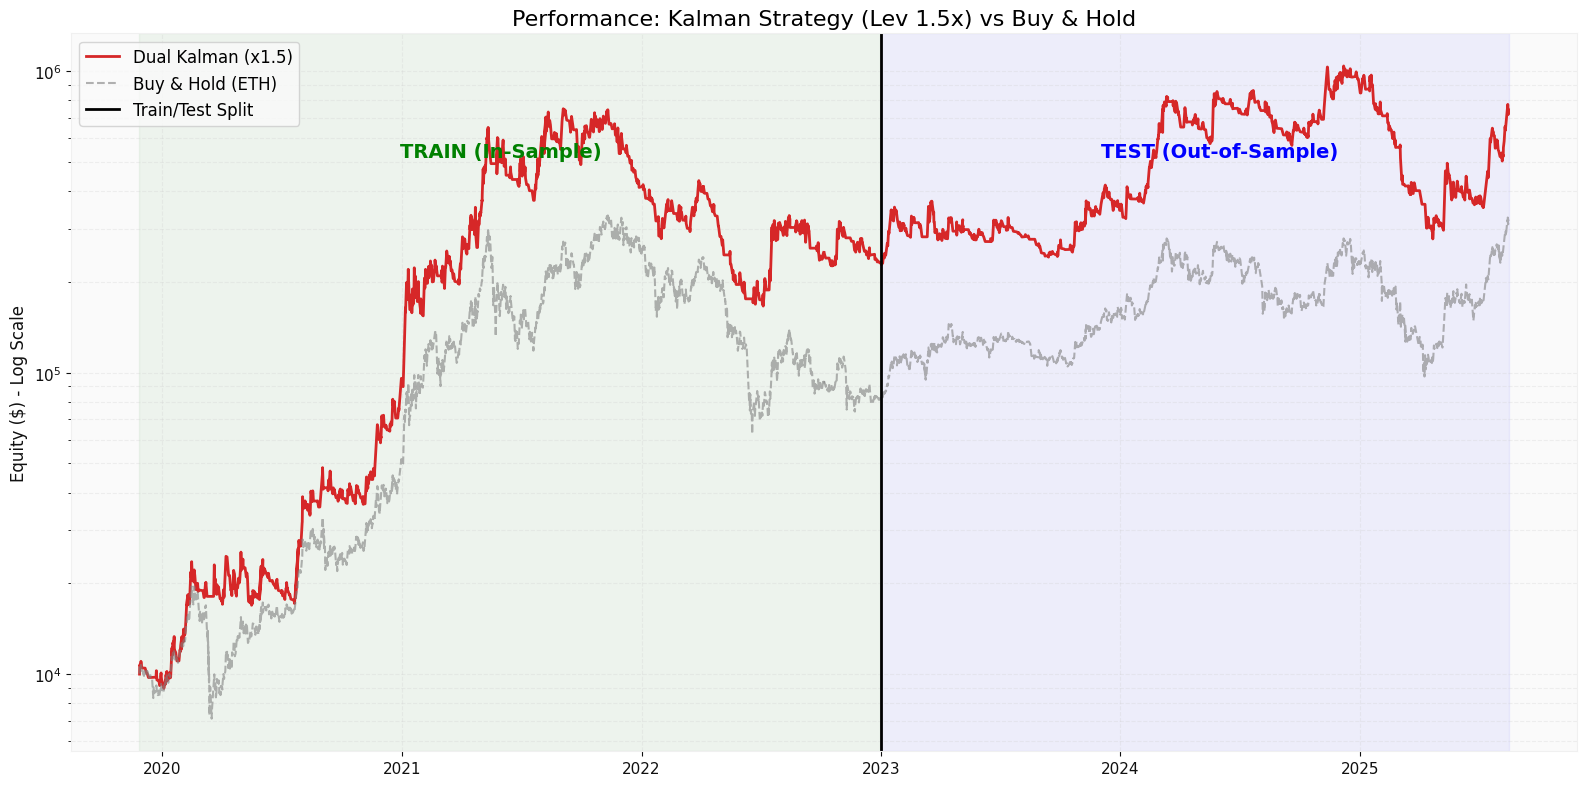

In [10]:
# Equity Curve
plt.figure(figsize=(16, 8))

plt.plot(df_strat.index, df_strat['Equity_Strategy'], label=f'Dual Kalman (x{LEVERAGE})', color='#d62728', linewidth=2)
plt.plot(df_strat.index, df_strat['Equity_BuyHold'], label='Buy & Hold (ETH)', color='gray', linestyle='--', alpha=0.6)

# Train/Test
plt.axvline(pd.Timestamp(TEST_START_DATE), color='black', linestyle='-', linewidth=2, label='Train/Test Split')

# Coloring background
plt.axvspan(df_strat.index[0], pd.Timestamp(TRAIN_END_DATE), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp(TEST_START_DATE), df_strat.index[-1], color='blue', alpha=0.05)

# Note
plt.text(pd.Timestamp('2021-06-01'), df_strat['Equity_Strategy'].max()*0.5, "TRAIN (In-Sample)", 
         fontsize=14, color='green', fontweight='bold', ha='center')
plt.text(pd.Timestamp('2024-06-01'), df_strat['Equity_Strategy'].max()*0.5, "TEST (Out-of-Sample)", 
         fontsize=14, color='blue', fontweight='bold', ha='center')

plt.yscale('log') # Thang logarit
plt.title(f'Performance: Kalman Strategy (Lev {LEVERAGE}x) vs Buy & Hold', fontsize=16)
plt.ylabel('Equity ($) - Log Scale', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Enhancement: Using Random Forest to get winning probability of Kalman. Decide which leverage to be used (changable, not fix 1.5)
## If it high --> raise leverage to 2.0x, if it low --> reduce leverage 0.5x

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("\n" + "="*60)
print(" 🚀 BLOCK 8: MACHINE LEARNING TRAINING (META-LABELING)")
print("="*60)

# FEATURE ENGINEERING 
df_ml = df_strat.copy()

if 'best_params_dual' in locals():
    q_fast = best_params_dual['q_fast']
    q_slow = best_params_dual['q_slow']
else:
    q_fast = 0.003; q_slow = 0.0001 # Giá trị fallback

# Kalman calculating
df_ml['K_Fast'] = calculate_kalman(df_ml['Close'], q=q_fast)
df_ml['K_Slow'] = calculate_kalman(df_ml['Close'], q=q_slow)

# Important feature
# 1. Spread: gap between q_fast, q_slow
df_ml['F_Spread'] = (df_ml['K_Fast'] - df_ml['K_Slow']) / df_ml['Close']

# 2. Volatility_20
df_ml['F_Vol'] = df_ml['Close'].pct_change().rolling(20).std()

# 3. RSI
delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df_ml['F_RSI'] = 100 - (100 / (1 + rs))

# 4. Volume Trend
df_ml['F_Vol_Trend'] = df_ml['Volume'] / (df_ml['Volume'].rolling(20).mean() + 1)

# Labeling
# Shift(-1) to get return as label for model to learn
df_ml['Future_Return'] = df_ml['Strategy_Net'].shift(-1)
df_ml['Label'] = np.where(df_ml['Future_Return'] > 0, 1, 0) # 1=Thắng, 0=Thua

# Drop nan
df_ml.dropna(inplace=True)

# Train/Test split
train_mask = df_ml.index <= TRAIN_END_DATE
test_mask = df_ml.index >= TEST_START_DATE

features = ['F_Spread', 'F_Vol', 'F_RSI', 'F_Vol_Trend']
target = 'Label'

X_train = df_ml.loc[train_mask, features]
y_train = df_ml.loc[train_mask, target]

# Model Training
print("Đang huấn luyện Random Forest...")
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Features importance
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print("\nĐộ quan trọng của các yếu tố (Feature Importance):")
print(importances)


 🚀 BLOCK 8: MACHINE LEARNING TRAINING (META-LABELING)
Đang huấn luyện Random Forest...

Độ quan trọng của các yếu tố (Feature Importance):
F_Spread       0.786922
F_RSI          0.195411
F_Vol          0.012800
F_Vol_Trend    0.004868
dtype: float64




 BẢNG SO SÁNH HIỆU SUẤT (TEST SET 2023-NAY)


,Fixed (1.5x),ML Dynamic (0.5x-2x)
Ann. Return,56.41%,33.98%
Sharpe Ratio,1.02,1.03
Max Drawdown,-73.32%,-52.56%
Win Rate,30.10%,29.59%
Profit Factor,1.58,1.54
Avg Win,10.71%,5.48%
Avg Loss,-2.92%,-1.49%
Alpha,nan%,nan%
Total Trades,195,195


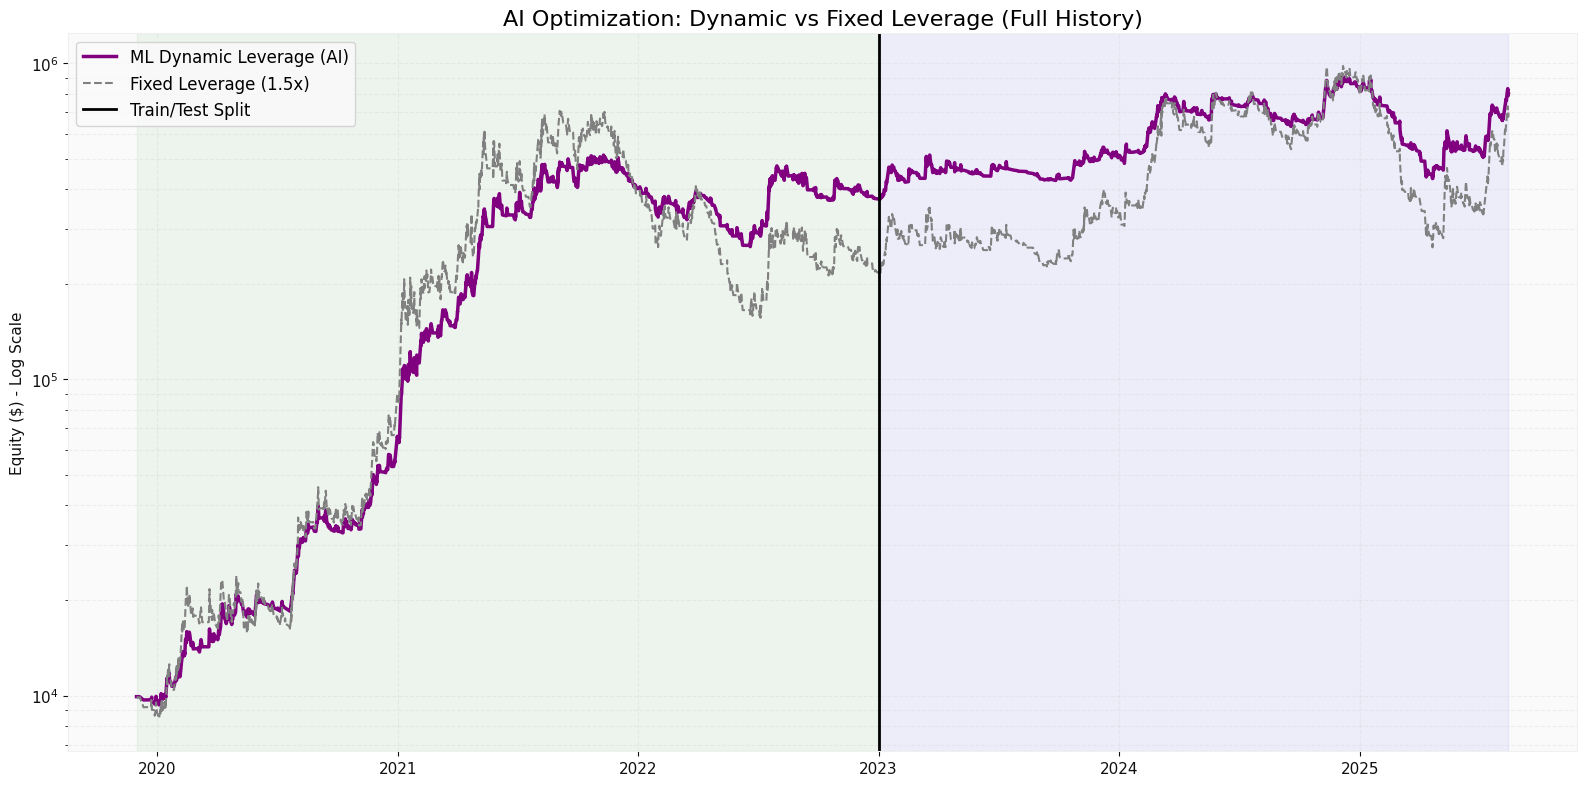


=== Checking whether model see the future or not ===
                     Prob_Win  Raw_Lev  Dyn_Lev
datetime                                       
2025-08-14 08:00:00  0.504605      1.0      1.0
2025-08-14 12:00:00  0.506889      1.0      1.0
2025-08-14 16:00:00  0.504891      1.0      1.0
2025-08-14 20:00:00  0.490318      0.5      1.0
2025-08-15 00:00:00  0.500843      1.0      0.5
'Dyn_Lev' of the below line must equals to 'Raw_Lev' of the above line


In [12]:
# STRATEGY COMPARISON AFTER USING ML (WITH DETAILED METRICS)

print("\n" + "="*80)
print("="*80)

X_full = df_ml[features]

# Prob profit at time t
probs = clf.predict_proba(X_full)[:, 1]
df_ml['Prob_Win'] = probs

# Leverage
def get_dynamic_leverage(probability):
    if probability > 0.55: return 2.0  
    elif probability > 0.50: return 1.0 
    else: return 0.5                    

# Leverage at t
df_ml['Raw_Lev'] = df_ml['Prob_Win'].apply(get_dynamic_leverage)

# SHIFT(1) - Avoid seeing future to test model
# Decision for after the moment t are made based on the data from the past until t
df_ml['Dyn_Lev'] = df_ml['Raw_Lev'].shift(1).fillna(1.0)

# Profit from ML
base_gross_return = df_ml['Strategy_Net'] / LEVERAGE 

# Return ML
df_ml['Strategy_ML'] = base_gross_return * df_ml['Dyn_Lev']

# Equity Curve
df_ml['Equity_ML'] = 10000 * (1 + df_ml['Strategy_ML']).cumprod()
df_ml['Equity_Fixed'] = 10000 * (1 + df_ml['Strategy_Net']).cumprod()

# Compare fixed Leverage vs ML 
# 2023-Now
test_data = df_ml.loc[test_mask]
benchmark_ret = test_data['Close'].pct_change()

pos_series = df_ml.loc[test_mask, 'Position'] 

# Metrics for Fixed Strategy
m_fixed = get_full_metrics(test_data['Strategy_Net'], benchmark_ret, pos_series)

# Metrics for ML Strategy
m_ml = get_full_metrics(test_data['Strategy_ML'], benchmark_ret, pos_series)

# Create DataFrame for comparing
df_compare = pd.DataFrame({
    f'Fixed ({LEVERAGE}x)': m_fixed,
    'ML Dynamic (0.5x-2x)': m_ml
})

print("\n" + "="*50)
print(f" BẢNG SO SÁNH HIỆU SUẤT (TEST SET 2023-NAY)")
print("="*50)
display(df_compare)

# Figure
plt.figure(figsize=(16, 8))
plt.plot(df_ml.index, df_ml['Equity_ML'], color='purple', linewidth=2.5, label='ML Dynamic Leverage (AI)')
plt.plot(df_ml.index, df_ml['Equity_Fixed'], color='gray', linestyle='--', linewidth=1.5, label=f'Fixed Leverage ({LEVERAGE}x)')

# Boundary line train/test
plt.axvline(pd.Timestamp(TEST_START_DATE), color='black', linestyle='-', linewidth=2, label='Train/Test Split')

# Background color
plt.axvspan(df_ml.index[0], pd.Timestamp(TRAIN_END_DATE), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp(TEST_START_DATE), df_ml.index[-1], color='blue', alpha=0.05)

plt.yscale('log')
plt.title('AI Optimization: Dynamic vs Fixed Leverage (Full History)', fontsize=16)
plt.ylabel('Equity ($) - Log Scale')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Checking logic shift one more time
print("\n=== Checking whether model see the future or not ===")
print(df_ml[['Prob_Win', 'Raw_Lev', 'Dyn_Lev']].tail(5))
print("'Dyn_Lev' of the below line must equals to 'Raw_Lev' of the above line")